In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from sigpy.mri import retro, sms

import os
DIR = os.getcwd()
print('> current directory: ', DIR)

DAT_DIR = DIR.rsplit('/', 1)[0] + '/data'
print('> data directory: ', DAT_DIR)

> current directory:  /home/atuin/b143dc/b143dc15/Softwares/scripts_diff_jets_7t/figure_gt
> data directory:  /home/atuin/b143dc/b143dc15/Softwares/scripts_diff_jets_7t/data


* read in k-space data and coils

In [2]:
N_shot = 4

f = h5py.File(DAT_DIR + '/' + str(N_shot) + 'shot_020dir_1.0mm_kdat_slice_013.h5', 'r')
kdat = f['kdat'][:]
N_band = f['MB'][()]
N_segments = f['Segments'][()]
N_slices = f['Slices'][()]
N_Accel_PE = f['Accel_PE'][()]
f.close()

print('> kdat shape: ', kdat.shape)
print('> N_band ' + str(N_band) + ' N_segments ' + str(N_segments) + ' N_slices ' + str(N_slices) + ' Accel_PE ' + str(N_Accel_PE))

f = h5py.File(DAT_DIR + '/' + str(N_shot) + 'shot_020dir_1.0mm_coil.h5', 'r')
coil = f['coil'][:]

coil1 = coil[:, [27, 74, 121], :, :]
print('> coil1 shape: ', coil1.shape)

N_y, N_x = coil1.shape[-2:]

> kdat shape:  (1, 1, 1, 1, 1, 1, 1, 20, 1, 1, 1, 1, 1, 200, 32, 200)
> N_band 3 N_segments 4 N_slices 141 Accel_PE 1
> coil1 shape:  (32, 3, 200, 200)


* compute SMS phase shift

In [3]:
# SMS phase shift
yshift = []
for b in range(N_band):
    yshift.append(b / N_Accel_PE)

sms_phase = sms.get_sms_phase_shift([N_band, N_y, N_x], 
                                    MB=N_band, 
                                    yshift=yshift)

 > sms: yshift  [0.0, 1.0, 2.0]


* split k-space data into shots

In [4]:
kdat = np.squeeze(kdat)
kdat = np.swapaxes(kdat, -2, -3)

N_diff = kdat.shape[-4]
kdat_prep = []
for d in range(N_diff):
    k = retro.split_shots(kdat[d, ...], shots=N_segments)
    kdat_prep.append(k)

kdat_prep = np.array(kdat_prep)
kdat_prep = kdat_prep[..., None, :, :]  # 6 dim

N_diff = kdat_prep.shape[0]

print('> kdat_prep shape: ', kdat_prep.shape)

> kdat_prep shape:  (20, 4, 32, 1, 200, 200)


* plot central k-space region of every segment

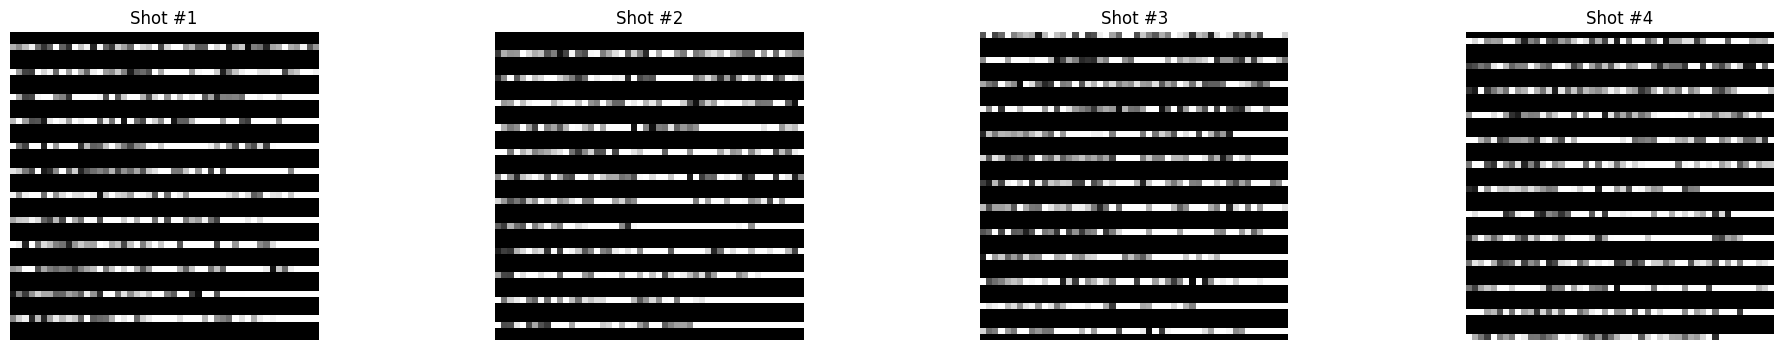

In [5]:
f, ax = plt.subplots(1, 4, figsize=(24, 4))

for s in range(N_segments):
    ax[s].imshow(abs(np.squeeze(kdat_prep[0, s, 0, 0, N_y//4:N_y//2, N_x//4:N_x//2])), cmap='gray', vmin=0, vmax=1e-5, interpolation='none')
    # ax[s].imshow(abs(np.squeeze(kdat_prep[0, s, 0, 0, :, :])), cmap='gray', vmin=0, vmax=1e-5, interpolation='none')
    ax[s].set_title('Shot #' + str(s+1))
    ax[s].set_axis_off()

plt.show()

* retrospectively undersampling

In [6]:
N_segments_retro = 1

N_Accel_PE_retro = N_segments // N_segments_retro

kdat_retr_shape = [kdat_prep.shape[0]] + [N_segments_retro] + list(kdat_prep.shape[2:])

print('> kdat_retr_shape: ', kdat_retr_shape)

# shift 1 !!!
kdat_retr1 = np.zeros_like(kdat_prep, shape=kdat_retr_shape)
for d in range(N_diff):
    shift = d % N_Accel_PE_retro
    
    if N_segments_retro == 1:
        segment_ind = [shift]
    else:
        segment_ind = [shift, N_Accel_PE_retro + shift]
    
    kdat_retr1[d, ...] = kdat_prep[d, segment_ind, ...]
    
    print('> diff ' + str(d).zfill(2) + ' segment_ind ' + str(segment_ind))

# shift 0 !!!
kdat_retr0 = np.zeros_like(kdat_prep, shape=kdat_retr_shape)
kdat_retr0 = kdat_prep[:, [0, 3], ...]

> kdat_retr_shape:  [20, 1, 32, 1, 200, 200]
> diff 00 segment_ind [0]
> diff 01 segment_ind [1]
> diff 02 segment_ind [2]
> diff 03 segment_ind [3]
> diff 04 segment_ind [0]
> diff 05 segment_ind [1]
> diff 06 segment_ind [2]
> diff 07 segment_ind [3]
> diff 08 segment_ind [0]
> diff 09 segment_ind [1]
> diff 10 segment_ind [2]
> diff 11 segment_ind [3]
> diff 12 segment_ind [0]
> diff 13 segment_ind [1]
> diff 14 segment_ind [2]
> diff 15 segment_ind [3]
> diff 16 segment_ind [0]
> diff 17 segment_ind [1]
> diff 18 segment_ind [2]
> diff 19 segment_ind [3]


* plot kdat with shifting

In [8]:
f, ax = plt.subplots(N_segments_retro, N_Accel_PE_retro)

for m in range(N_segments_retro):
    for n in range(N_Accel_PE_retro):
        ax[m, n].imshow(abs(np.squeeze(kdat_retr1[n, m, 0, 0, N_y//4:N_y//2, N_x//4:N_x//2])), cmap='gray', vmin=0, vmax=1e-5, interpolation='none')
        ax[m, n].set_axis_off()
        ax[m, n].set_title('Shot #' + str(m+1) + ' in Diff #' + str(n+1))

plt.show()

* plot kdat without shifting

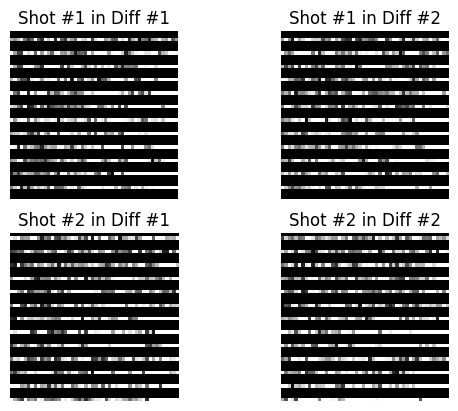

In [8]:
f, ax = plt.subplots(N_segments_retro, N_Accel_PE_retro)

for m in range(N_segments_retro):
    for n in range(N_Accel_PE_retro):
        ax[m, n].imshow(abs(np.squeeze(kdat_retr0[n, m, 0, 0, N_y//4:N_y//2, N_x//4:N_x//2])), cmap='gray', vmin=0, vmax=1e-5, interpolation='none')
        ax[m, n].set_axis_off()
        ax[m, n].set_title('Shot #' + str(m+1) + ' in Diff #' + str(n+1))

plt.show()